# Embedding Adaptors

Embedding adapters are a way to use feedback of th relevancy of retrieved results to improve the performance of the retreival

We can use synthetic data to enhance retrieval. 

## Installation

Take a look at requirnments.txt

We will be installing PyTorch for this exercise. 

In [1]:
%pip install -q -r requirements.txt


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Helper function to display the results of the vector search

In [2]:
def print_results_and_documents(results, retrieved_documents, word_wrap):
    """
    Prints keys and values from the results dictionary and documents with word wrapping.

    Args:
        results (dict): A dictionary where keys are strings and values are either strings or lists.
        retrieved_documents (list): A list of documents to be printed.
        word_wrap (function): A function to apply word wrapping to the documents.

    Returns:
        None
    """
    # Iterate through the dictionary and print each key with its associated value
    for key, value in results.items():
        print(f"{key}:")

        # Check if the value is a list and print its elements
        if isinstance(value, list):
            for i, item in enumerate(value):
                print(f"  Item {i+1}: {item}")
        else:
            # Directly print the value if it's not a list
            print(f"  {value}")

        print()  # Add a newline for better readability

    # Iterate through the list of documents and print each one with word wrapping
    for document in retrieved_documents:
        print(word_wrap(document))
        print('\n')

## Connecting to the vector database

In [3]:
import chromadb
from helper_utils import load_chroma, word_wrap, project_embeddings
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
from chromadb.config import DEFAULT_TENANT, DEFAULT_DATABASE, Settings
import numpy as np
import umap
from tqdm import tqdm
import torch

chroma_client = chromadb.PersistentClient(
    path="data/chroma_db/",
    settings=Settings(),
    tenant=DEFAULT_TENANT,
    database=DEFAULT_DATABASE,
)
# Load the existing collection by its name
collection_name = 'microsoft_annual_report_2022'
chroma_collection = chroma_client.get_or_create_collection(name=collection_name)

# Count the number of items in the collection
count = chroma_collection.count()
print(f"Number of items in the collection '{collection_name}': {count}")

/Users/johnwillis/.pyenv/versions/3.11.9/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of items in the collection 'microsoft_annual_report_2022': 349


## Setting up the embedding function

Select the model.

In [4]:
# Access the underlying SentenceTransformer model (Defults)
embedding_function = SentenceTransformerEmbeddingFunction()
model = embedding_function.models
print(model)

{'all-MiniLM-L6-v2': SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)}


## Retrieve the embeddings

Project out model (i.e., UMAP). The projected dataset embeddings. 

In [5]:
embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

/Users/johnwillis/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/johnwillis/.pyenv/versions/3.11.9/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
  0%|          | 0/349 [00:00<?, ?it/s]/Users/johnwillis/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
  0%|          | 1/349 [00:00<05:22,  1.08it/s]/Users/johnwillis/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite

## Creating a synthetic dataset with OpenAI

Use a query to generate a dataset. Use an LLM to generate a dataswet of questions. Check out the prompt. 

Note beware of the output format of the questions. If I use gpt-4o-min I get actually newlines which get counted as 29 lines of output and could effect the next query

In [9]:
from openai import OpenAI
openai_client=OpenAI()

def generate_queries(model="gpt-4o"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. You help users analyze financial statements to better understand companies. "
            "Suggest 10 to 15 short questions that are important to ask when analyzing an annual report. "
            "Do not output any compound questions (questions with multiple sentences or conjunctions)."
            "Output each question on a separate line divided by a newline."
        },
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content

We use GPT to generate a dataset of expert questions from GPT-4o-mini.

In [10]:
generated_queries = generate_queries()
for query in generated_queries:
    print(query)

What is the company's revenue growth compared to the previous year?  
How has the company's profitability margin changed over the year?  
What are the major components of the company's operating expenses?  
How has the company's cash flow from operations changed?  
What is the company's current ratio?  
What are the company’s major sources of revenue?  
How much debt does the company currently hold?  
What is the company’s debt-to-equity ratio?  
How have the company's earnings per share (EPS) evolved?  
What are the significant changes in the company's asset base?  
How does the company's return on equity (ROE) compare to industry norms?  
What are the external factors mentioned that might affect the company's performance?  
What major investments has the company made during the year?  
Are there any notes on legal or regulatory risks in the financial statement?  
How does the company's performance compare to its closest competitors?


We asked the LLM (GPT) to generate 15 questions. Now we ask thes 15 questions against our chromDB vector store to get the relavant chunks.

In [18]:
results = chroma_collection.query(query_texts=generated_queries,
                                   n_results=10, 
                                   include=['documents', 'embeddings', "distances"])

retrieved_documents = results['documents'][0]
print_results_and_documents(results, retrieved_documents, word_wrap)

for document in results['documents'][0]:
    print(word_wrap(document))
    print('')

ids:
  Item 1: ['145', '36', '127', '134', '146', '141', '151', '125', '188', '293']
  Item 2: ['142', '147', '36', '144', '134', '125', '146', '145', '324', '161']
  Item 3: ['152', '319', '208', '78', '150', '318', '207', '142', '184', '227']
  Item 4: ['166', '200', '319', '295', '202', '152', '206', '162', '169', '125']
  Item 5: ['323', '36', '134', '161', '125', '242', '140', '272', '195', '145']
  Item 6: ['210', '320', '152', '319', '318', '331', '323', '145', '149', '139']
  Item 7: ['167', '278', '273', '169', '277', '198', '222', '323', '172', '205']
  Item 8: ['179', '167', '277', '206', '273', '205', '202', '324', '198', '197']
  Item 9: ['242', '195', '140', '161', '243', '206', '324', '205', '207', '227']
  Item 10: ['272', '134', '208', '162', '125', '188', '78', '205', '132', '324']
  Item 11: ['180', '208', '193', '36', '243', '324', '125', '205', '184', '313']
  Item 12: ['208', '150', '215', '133', '143', '142', '342', '147', '80', '144']
  Item 13: ['162', '323', '

In [20]:
retrieved_documents = results['documents']
print(len(retrieved_documents))

15


Then we query those questions against our embeddings (ChromaDB).

## Judging the results

Use the query of synthetic questions and a new prompt to evalaute the retreval based on out questions (i.e.,

"For the given query, evaluate whether the following satement is relevant."
        "Output only 'yes' or 'no'.")    

In [21]:
def evaluate_results(query, statement, model="gpt-4o-mini"):
    messages = [
    {
        "role": "system",
        "content": "You are a helpful expert financial research assistant. You help users analyze financial statements to better understand companies. "
        "For the given query, evaluate whether the following satement is relevant."
        "Output only 'yes' or 'no'."
    },
    {
        "role": "user",
        "content": f"Query: {query}, Statement: {statement}"
    }
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
        max_tokens=1
    )
    content = response.choices[0].message.content
    if content == "yes":
        return 1
    return -1

The evaluate_results function above should return 1 or -1 as the expert (LLM Judge) from the prompt of the "query" and "statement".  The statement will be the chunck.

## Setup the embeddings

In [22]:
retrieved_embeddings = results['embeddings']
query_embeddings = embedding_function(generated_queries)

adapter_query_embeddings are the original queries 

adapter_doc_embeddings are the chunks returned from the queries

adapter_labels are are the judged (-1 or 1)

In [23]:
#Embedddings of our queries
adapter_query_embeddings = []
#Embeddings of our documents
adapter_doc_embeddings = []
# Labels will come from the evalation model (1 or -1)
adapter_labels = []

This should make your head hurt...

- Basically we are  reating a loop of all the generated queries. 
- Then an inner loop to incorparate the chunk (doc) and the..
- query embeddings and the generated query embeddings
- Lastly, the results (i.e., the labels/judge (1 or -1))

Note: When using cosine similarity, 1 is where vectors point in the same direction and -1 is wherethey point in the opposite direction (1=relevant and -1=irrelevant).  

In [24]:
for q, query in enumerate(tqdm(generated_queries)):
    for d, document in enumerate(retrieved_documents[q]):
        adapter_query_embeddings.append(query_embeddings[q])
        adapter_doc_embeddings.append(retrieved_embeddings[q][d])
        adapter_labels.append(evaluate_results(query, document))

100%|██████████| 15/15 [01:16<00:00,  5.12s/it]


Labels are going to be the output of our loss function (evalaute_results)
With cosine similatity 1 = identical and -1 = oppisite.    

In [25]:
len(adapter_labels)

150

Fifteen queries with 10 results each. Each one is labeled for relavancy. 

## Converting to Pytorch sensor

15 questions with 10 results each (150). Now we perform a conversion of the adapter_query_embeddings variable into a PyTorch tensor. Has to be a NumPy array. Labels are the (yes=1) or (no=-1)

We are going to transform out datasets into torch tensor datasets.

In [26]:
adapter_query_embeddings = torch.Tensor(np.array(adapter_query_embeddings))
adapter_doc_embeddings = torch.Tensor(np.array(adapter_doc_embeddings))
adapter_labels = torch.Tensor(np.expand_dims(np.array(adapter_labels),1))

We need to turn our dataset into one torch tensor dataset

In [27]:
dataset = torch.utils.data.TensorDataset(adapter_query_embeddings, adapter_doc_embeddings, adapter_labels)

## Setting up a model

We will take the three inputs (the embddings og the queries, the embddings of the retrieved chunks, and the the new adapted matrix). We multiply the adapter_matrix by the query_embeddings. The we return the cosine similarity between the updated embedddings and the document embedding (the synthetic queries)

Note: The adapter matrix will be the random matrix generated of random numbers between 1 and -1. 

### **Why Do We Do This in the Model?**
The function:
```python
def model(query_embedding, document_embedding, adaptor_matrix):
    updated_query_embedding = torch.matmul(adaptor_matrix, query_embedding)
    return torch.cosine_similarity(updated_query_embedding, document_embedding, dim=0)
```
**performs two key operations**:
1. **Transforms the `query_embedding` using the `adaptor_matrix`**
2. **Computes cosine similarity between the transformed query and the document embedding**

Let’s break down **why we do each step** and when this might be useful.

---

## **Step 1: Transforming the Query Embedding**
```python
updated_query_embedding = torch.matmul(adaptor_matrix, query_embedding)
```
🔹 **Why?**
- The `adaptor_matrix` modifies `query_embedding` before similarity calculation.
- This transformation **learns a new representation** of the query that may better align with the document embedding.
- It's particularly useful in **transfer learning**, **domain adaptation**, or **fine-tuning**.

🔹 **Where is this useful?**
- **Cross-domain similarity**: If `query_embedding` and `document_embedding` come from **different distributions** (e.g., different languages, modalities), the `adaptor_matrix` can help bridge the gap.
- **Fine-tuning embeddings**: Helps adjust pretrained embeddings to a new dataset.
- **Attention mechanisms**: Adapters can function like attention weights.

---

## **Step 2: Computing Cosine Similarity**
```python
return torch.cosine_similarity(updated_query_embedding, document_embedding, dim=0)
```
🔹 **Why?**
- Cosine similarity measures how **directionally aligned** two vectors are, irrespective of their magnitude.
- This is commonly used in **information retrieval**, **semantic similarity tasks**, and **recommendation systems**.
- Since we applied `adaptor_matrix`, we check if the transformation improves similarity.

🔹 **Example Scenario: Query-Document Matching**
Imagine a search system where:
- The **query_embedding** represents a user’s search.
- The **document_embedding** represents a document in the database.
- The **adaptor_matrix** helps align the query to the document space.

By transforming the query first and then computing similarity, we **increase the likelihood** of retrieving relevant documents.

---

## **Summary**
🔹 **Step 1:** `adaptor_matrix` adjusts `query_embedding` → Helps in learning better alignment.  
🔹 **Step 2:** Cosine similarity measures relevance between transformed query and document.  
🔹 **Use Cases:** **Transfer learning, retrieval systems, domain adaptation, fine-tuning embeddings.**  


Note: We now compare the cosine similarity between the new adapted matrix and the synthentic questions

In [31]:
def model(query_embedding, document_embedding, adaptor_matrix):
    updated_query_embedding = torch.matmul(adaptor_matrix, query_embedding)
    return torch.cosine_similarity(updated_query_embedding, document_embedding, dim=0)

Then we compete the mean square error (mean squared deviation). In simple term we want our queries to be pointing in the same direction of the relevant documents and in the oppsote direction to the irrelevant documents (based on the 1 or -1 label)

In [32]:
def mse_loss(query_embedding, document_embedding, adaptor_matrix, label):
    return torch.nn.MSELoss()(model(query_embedding, document_embedding, adaptor_matrix), label)

The following code creates a random matrix. This matrix is randomly initialized and is set up so that it can be learned during the training process. This generates a matrix of size 384 with elements drawn from a standard normal distribution (mean = 0, variance = 1).

requires_grad=True:
This flag tells PyTorch that it should keep track of gradients for this tensor during backpropagation. This means the adapter_matrix will be updated during the training process, allowing it to learn a transformation that is optimized for the task at hand.

Note: Randomly setting vectors before training ensures diversity in learning, prevents symmetry issues, and improves gradient flow, leading to effective model training. 

In [33]:
# Initialize the adaptor matrix
mat_size = len(adapter_query_embeddings[0])
print("vector dimension ",mat_size)
# generates a tensor with random values sfrom a standard normal distribution (mean = 0, variance = 1).
adapter_matrix = torch.randn(mat_size, mat_size, requires_grad=True)

vector dimension  384


Train for 100 epochs. An epoch is one complete pass through the entire training dataset during model training. If our loss is better than out last loss we'll keep track of it. Then we backpropagate. 

In [40]:
min_loss = float('inf')
best_matrix = None

for epoch in tqdm(range(100)):
    for query_embedding, document_embedding, label in dataset:
        loss = mse_loss(query_embedding, document_embedding, adapter_matrix, label)

        if loss < min_loss:
            min_loss = loss
            best_matrix = adapter_matrix.clone().detach().numpy()

        loss.backward()
        with torch.no_grad():
            adapter_matrix -= 0.01 * adapter_matrix.grad
            adapter_matrix.grad.zero_()
        

  0%|          | 0/100 [00:00<?, ?it/s]/Users/johnwillis/.pyenv/versions/3.11.9/lib/python3.11/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 100/100 [00:04<00:00, 20.36it/s]


In [41]:
print(f"Best loss: {min_loss.detach().numpy()}")

Best loss: 0.6445252299308777


Note: We got a best loss of less than .06. Which means we got aa littel less than a half way improvement in terms of where we started from. 

In [42]:
test_vector = torch.ones((mat_size,1))
scaled_vector = np.matmul(best_matrix, test_vector).numpy()

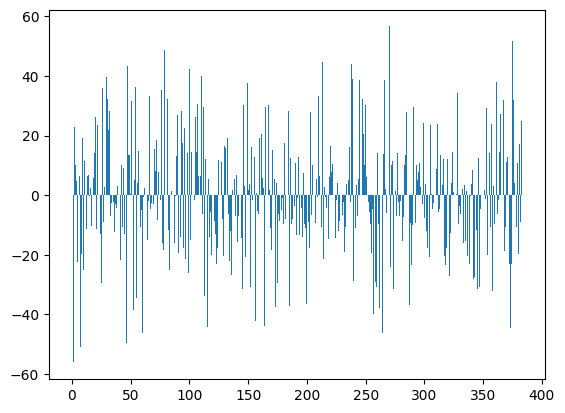

In [38]:
#import matplotlib.pyplot as plt
#plt.bar(range(len(scaled_vector)), scaled_vector.flatten())
#plt.show()

This is a plot of what it looks like. Each dimension of our test vector of 1's showing deminsions that have been stretched and based on relevancy.

In [43]:
query_embeddings = embedding_function(generated_queries)
adapted_query_embeddings = np.matmul(best_matrix, np.array(query_embeddings).T).T

projected_query_embeddings = project_embeddings(query_embeddings, umap_transform)
projected_adapted_query_embeddings = project_embeddings(adapted_query_embeddings, umap_transform)

  0%|          | 0/15 [00:00<?, ?it/s]/Users/johnwillis/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/johnwillis/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/johnwillis/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/johnwillis/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/johnwillis/.pyenv/versions/3.11.9/lib/python3.11/site-p

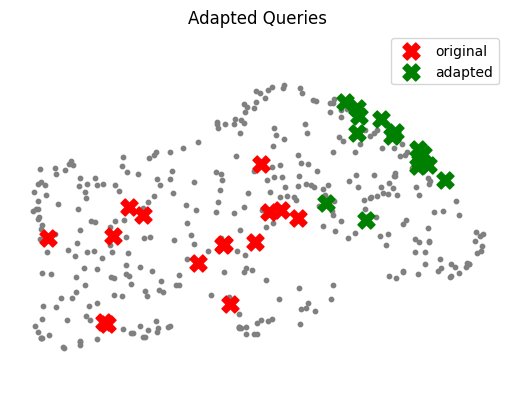

In [44]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embeddings[:, 0], projected_query_embeddings[:, 1], s=150, marker='X', color='r', label="original")
plt.scatter(projected_adapted_query_embeddings[:, 0], projected_adapted_query_embeddings[:, 1], s=150, marker='X', color='green', label="adapted")

plt.gca().set_aspect('equal', 'datalim')
plt.title("Adapted Queries")
plt.axis('off')
plt.legend()

Notice the adapted matrix is clustered to be more relavant. 